In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import join
import torch
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion.utils.misc import read_config, set_random_seed, \
    init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import visualize_prompts, PixArtAlphaPipeline_custom, \
    load_embed_and_mask, visualize_prompts_with_traj
from utils.pixart_utils import construct_diffuser_pipeline_from_config, construct_pixart_transformer_from_config, state_dict_convert
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Load models and tokenizer

In [33]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
ckptdir = join(savedir, "checkpoints")
config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
pipeline = construct_diffuser_pipeline_from_config(config, pipeline_class=PixArtAlphaPipeline_custom)
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
pipeline = pipeline.to("cuda")
pipeline.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
validation_prompts = config.validation_prompts
prompt_cache_dir = config.prompt_cache_dir

In [26]:
from transformers import T5Tokenizer, T5EncoderModel

T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")

### Systematic storing attention maps across time steps

In [4]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


In [46]:
attnvis_store.clear_activation()
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj(\
    pipeline, validation_prompts[5:6], prompt_cache_dir, config.model_max_length, weight_dtype)

embed_infos = load_embed_and_mask(validation_prompts[5:6], prompt_cache_dir, config.model_max_length, device="cuda")

print(embed_infos[0]['prompt'])
prompt = embed_infos[0]['prompt']
# attention_mask_raw = embed_infos[0]['emb_mask'].cpu()
token_ids = tokenizer.encode(prompt)
word_tokens = tokenizer.convert_ids_to_tokens(token_ids)
word_tokens = [token.replace("▁", "") for token in word_tokens]

torch.Size([50, 20, 4096])
torch.Size([50, 20])
triangle is to the left of triangle


In [47]:
layer_i = 11 # note the 
timestep = -1
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
print(self_attn_map.shape, cross_attn_map.shape)

torch.Size([50, 12, 64, 64]) torch.Size([50, 12, 64, 20])


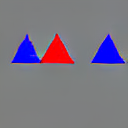

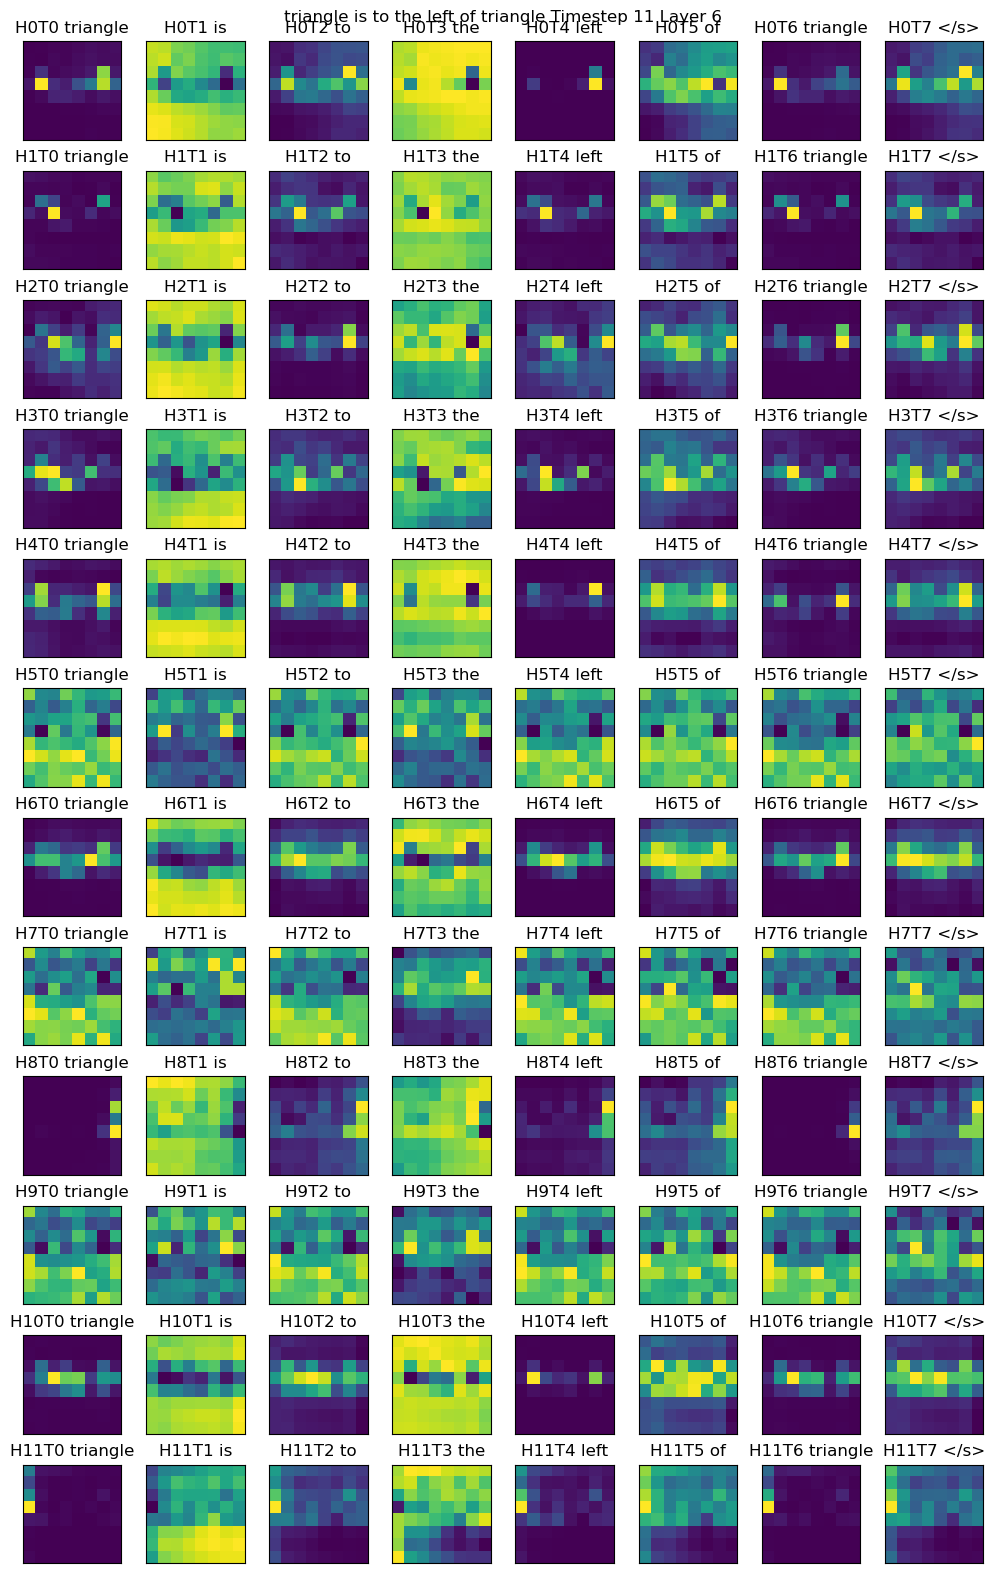

In [48]:
layer_i = 6 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
sample_id = 15
display(image_logs_sel[0]['images'][sample_id])
figh, axs = plt.subplots(12, len(word_tokens), figsize=(10, 16))
for head_id in range(12):
    for token_id in range(len(word_tokens)):
        ax = axs[head_id, token_id]
        ax.imshow(cross_attn_map[25 + sample_id, 
                                 head_id, :, 
                                 token_id].view(8, 8).cpu().numpy())
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'H{head_id}T{token_id} {word_tokens[token_id]}')
        
plt.suptitle(f'{prompt} Timestep {timestep} Layer {layer_i}')
plt.tight_layout()


### Visualize cross attention matrix 

In [87]:
prompt_slice = slice(0, 1)
attnvis_store.clear_activation()
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj(\
    pipeline, validation_prompts[prompt_slice], prompt_cache_dir, config.model_max_length, weight_dtype, random_seed=0)

embed_infos = load_embed_and_mask(validation_prompts[prompt_slice], prompt_cache_dir, config.model_max_length, device="cuda")
print(embed_infos[0]['prompt'])
prompt = embed_infos[0]['prompt']
# attention_mask_raw = embed_infos[0]['emb_mask'].cpu()
token_ids = tokenizer.encode(prompt)
word_tokens = tokenizer.convert_ids_to_tokens(token_ids)
word_tokens = [token.replace("▁", "") for token in word_tokens]
print(word_tokens)

torch.Size([50, 20, 4096])
torch.Size([50, 20])
triangle is to the upper left of square
['triangle', 'is', 'to', 'the', 'upper', 'left', 'of', 'square', '</s>']


In [88]:
layer_i = 11 # note the 
timestep = 1
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
print(self_attn_map.shape, cross_attn_map.shape)

torch.Size([50, 12, 64, 64]) torch.Size([50, 12, 64, 20])


In [89]:
word_tokens

['triangle', 'is', 'to', 'the', 'upper', 'left', 'of', 'square', '</s>']

#### High attention to "meaningless" tokens

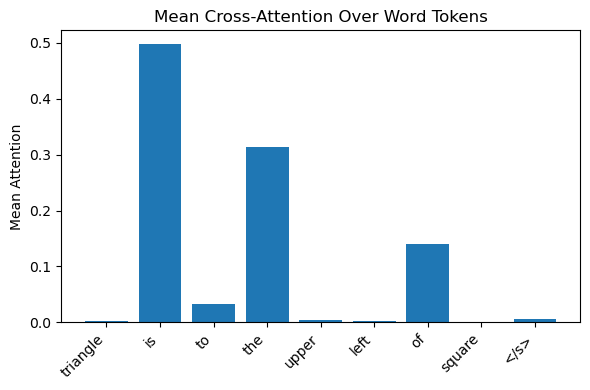

In [90]:

layer_i = 11 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]

plt.figure(figsize=(6, 4))
attn_means = cross_attn_map[25:, :, :, :].mean(dim=(0, 1, 2))
plt.bar(range(len(word_tokens)), attn_means[:len(word_tokens)])
plt.xticks(range(len(word_tokens)), word_tokens, rotation=45, ha='right')
plt.ylabel('Mean Attention')
plt.title('Mean Cross-Attention Over Word Tokens')
plt.tight_layout()
plt.show()

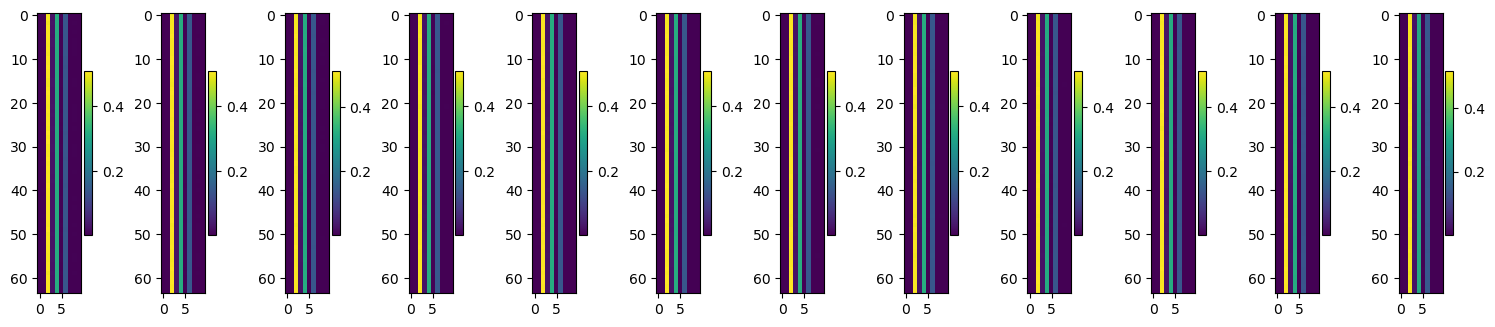

In [73]:
prompt_token_mask = embed_infos[0]['emb_mask'].cpu().squeeze(0).bool()
sample_id = 1
layer_i = 0 # note the 
timestep = 1
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
plt.figure(figsize=(15, 5))
for head_id in range(12): 
    plt.subplot(1, 12, head_id + 1)
    plt.imshow(cross_attn_map[25 + sample_id, head_id, :, prompt_token_mask].cpu().numpy())
    # plt.imshow(cross_attn_map[sample_id, head_id :, :].cpu().numpy())
    plt.colorbar()
    # plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
layer_i = 6 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
sample_id = 15
display(image_logs_sel[0]['images'][sample_id])
figh, axs = plt.subplots(12, len(word_tokens), figsize=(10, 16))
for head_id in range(12):
    for token_id in range(len(word_tokens)):
        ax = axs[head_id, token_id]
        ax.imshow(cross_attn_map[25 + sample_id, 
                                 head_id, :, 
                                 token_id].view(8, 8).cpu().numpy())
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'H{head_id}T{token_id} {word_tokens[token_id]}')
        
plt.suptitle(f'{prompt} Timestep {timestep} Layer {layer_i}')
plt.tight_layout()

In [ ]:
prompt_token_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Run diffusion with custom prompts

In [7]:
import os
import torch as th
from utils.image_utils import pil_images_to_grid
from utils.custom_text_encoding_utils import save_prompt_embeddings_randemb, RandomEmbeddingEncoder, RandomEmbeddingEncoder_wPosEmb

In [8]:
def tokenize_embed_prompt(prompt, tokenizer, text_encoder, max_length=20, device="cuda"):
    uncond = tokenizer("", max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
    uncond_prompt_embeds = text_encoder(uncond.input_ids, attention_mask=uncond.attention_mask)[0]
    uncond_result = {'caption_embeds': uncond_prompt_embeds, 'emb_mask': uncond.attention_mask, 'prompt': '', 'token_ids': uncond.input_ids}
    caption_token = tokenizer(prompt, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
    caption_emb = text_encoder(caption_token.input_ids, attention_mask=caption_token.attention_mask)[0]
    cond_result = {'caption_embeds': caption_emb, 'emb_mask': caption_token.attention_mask, 'prompt': prompt, 'token_ids': caption_token.input_ids}
    return uncond_result, cond_result

In [9]:
@torch.inference_mode()
def visualize_prompts_with_traj_from_embed_dict(pipeline, uncond_prompt_dict, cond_prompt_dict, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda", random_seed=0):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    if random_seed is None:
        generator = None
    else:
        generator = torch.Generator(device=device).manual_seed(random_seed)
    image_logs = []
    images = []
    latents = []
    pred_traj = []
    latents_traj = []
    t_traj = []
    visualized_prompts = []
    # uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_prompt_dict['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_prompt_dict['emb_mask'].to(device)
    # for _, prompt in enumerate(validation_prompts):
    caption_embs = cond_prompt_dict['caption_embeds'].to(device)
    emb_masks = cond_prompt_dict['emb_mask'].to(device)
    output = pipeline(
        num_inference_steps=num_inference_steps,
        num_images_per_prompt=num_images_per_prompt,
        generator=generator,
        guidance_scale=guidance_scale,
        prompt_embeds=caption_embs,
        prompt_attention_mask=emb_masks,
        negative_prompt=None,
        negative_prompt_embeds=uncond_prompt_embeds,
        negative_prompt_attention_mask=uncond_prompt_attention_mask,
        use_resolution_binning=False, # need this for smaller images like ours. 
        return_sample_pred_traj=True,
        output_type="latent",
    )
    latents.append(output[0].images)
    pred_traj.append(output[1])
    latents_traj.append(output[2])
    t_traj.append(output[3])
    visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})
    
    return image_logs, latents_traj, pred_traj, t_traj

In [41]:
@torch.inference_mode()
def pipeline_inference_custom(pipeline, prompt, negative_prompt="", num_inference_steps=14, num_images_per_prompt=25, guidance_scale=4.5, random_seed=0, max_sequence_length=20, 
                              return_sample_pred_traj=True, output_type="latent", device="cuda", weight_dtype=torch.float16, **kwargs):
    pipeline = pipeline.to(device)
    output = pipeline(prompt=prompt,
         negative_prompt=negative_prompt,
         num_inference_steps=num_inference_steps,
         num_images_per_prompt=num_images_per_prompt,
         generator=torch.Generator(device=device).manual_seed(random_seed),
         guidance_scale=guidance_scale,
         max_sequence_length=max_sequence_length,
         use_resolution_binning=False,
         return_sample_pred_traj=return_sample_pred_traj,
         output_type=output_type,
         **kwargs,
    )
    if return_sample_pred_traj:
        latents = output[0].images
        pred_traj = output[1]
        latents_traj = output[2]
        t_traj = output[3]
    else:
        latents = output.images
        pred_traj = None
        latents_traj = None
        t_traj = None
    images = pipeline.vae.decode(latents.clone().to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0]
    image_logs = []
    images = pipeline.image_processor.postprocess(images, output_type="pil")
    image_logs.append({"validation_prompt": prompt, "images": images})
    return image_logs, pred_traj, latents_traj, t_traj

In [42]:
pipeline._execution_device

AttributeError: 'PixArtAlphaPipeline_custom' object has no attribute '_execution_device'

In [43]:
pipeline = pipeline.to("cuda")

AttributeError: 'RandomEmbeddingEncoder_wPosEmb' object has no attribute 'dtype'

In [35]:
text_feat_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndembposemb/caption_feature_wmask'
tokenizer = T5Tokenizer.from_pretrained(T5_path)
rnd_encoding = th.load(join(text_feat_dir, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(rnd_encoding["embedding_dict"], 
                                              rnd_encoding["input_ids2dict_ids"], 
                                              rnd_encoding["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")
pipeline.text_encoder = rndpos_encoder
# pipeline.text_encoder.dtype = torch.float
pipeline.tokenizer = tokenizer

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "red blue triangle", return_sample_pred_traj=False, random_seed=0, device="cuda")
pil_images_to_grid(images_logs[0]['images'])

AttributeError: 'PixArtAlphaPipeline_custom' object has no attribute '_execution_device'

torch.Size([50, 20, 4096])
torch.Size([50, 20])


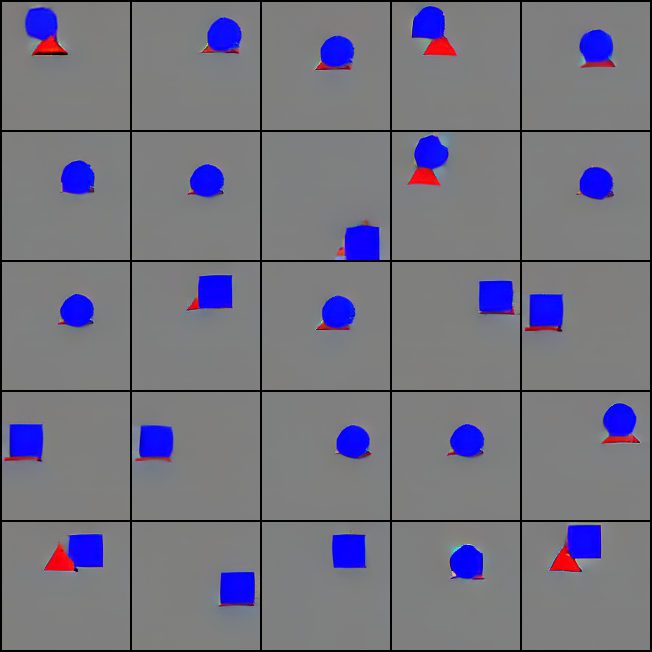

In [178]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "triangle red blue", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

torch.Size([50, 20, 4096])
torch.Size([50, 20])


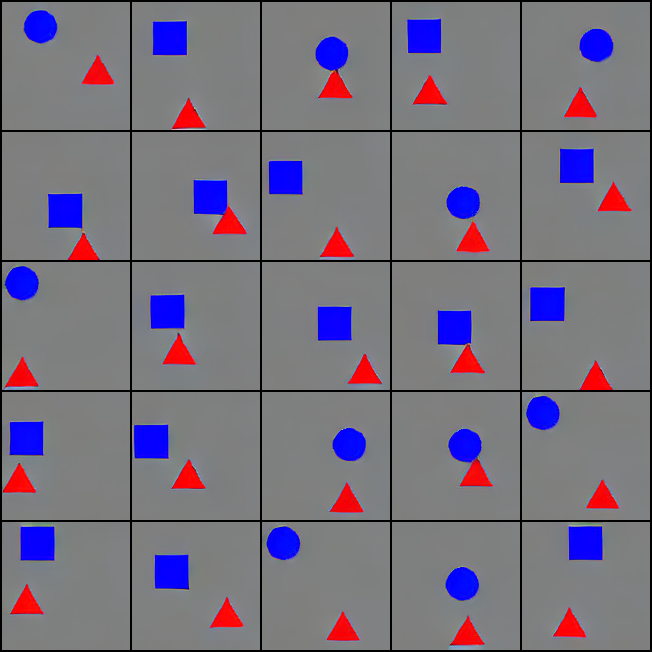

In [199]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "triangle red the the the the below ", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

torch.Size([50, 20, 4096])
torch.Size([50, 20])


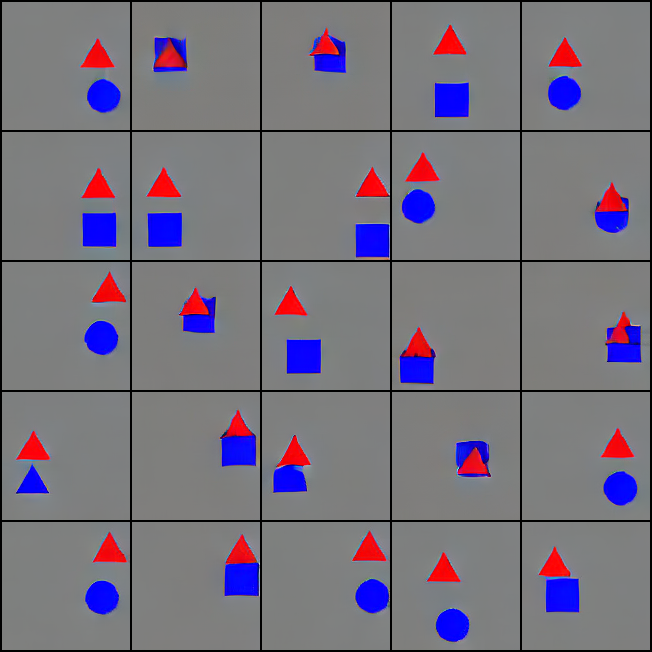

In [198]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "the the the the triangle red below ", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

torch.Size([50, 20, 4096])
torch.Size([50, 20])


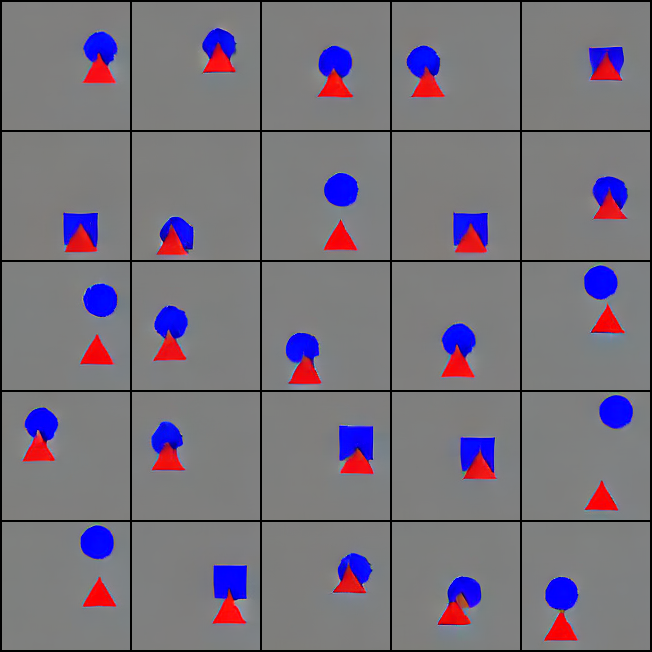

In [197]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "the the the the triangle red above ", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

torch.Size([50, 20, 4096])
torch.Size([50, 20])


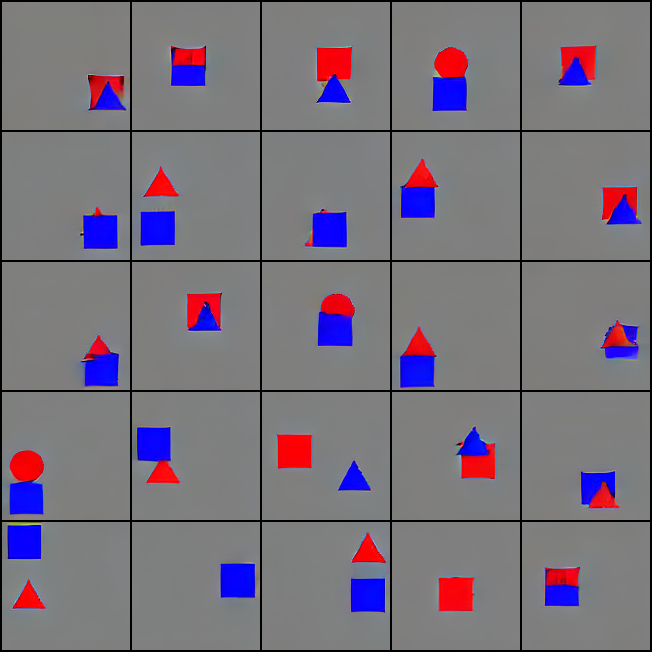

In [195]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "the the the triangle red square blue above ", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

torch.Size([50, 20, 4096])
torch.Size([50, 20])


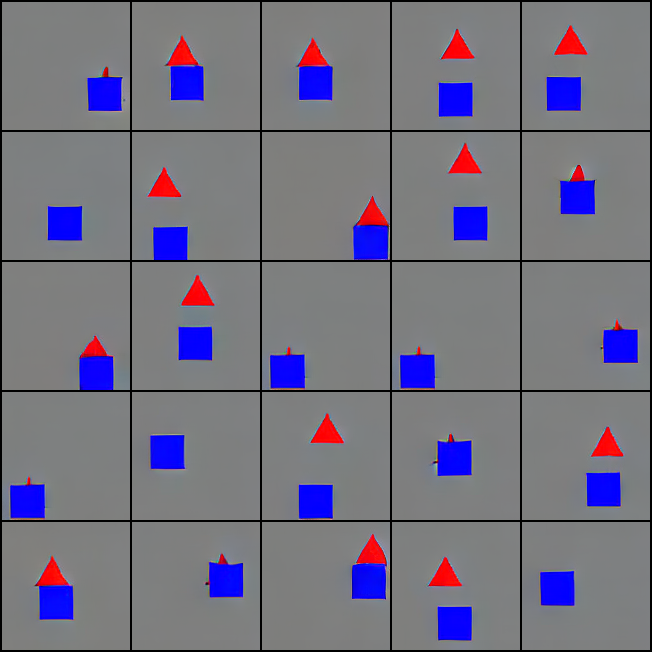

In [190]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "red triangle the the blue square above ", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

torch.Size([50, 20, 4096])
torch.Size([50, 20])


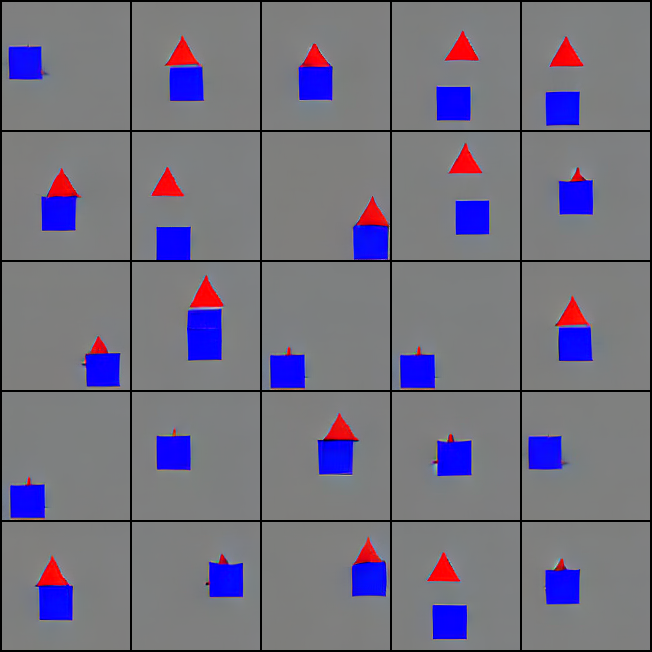

In [173]:
images_logs, _, _, _ = pipeline_inference_custom(pipeline, "above red triangle is blue square", return_sample_pred_traj=False, random_seed=0)
pil_images_to_grid(images_logs[0]['images'])

In [ ]:
images = []
for latent in latents:
    images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])

In [116]:
tokenize_embed_prompt("red square blue triangle", tokenizer, rndpos_encoder, max_length=20, device="cuda")

({'caption_embeds': tensor([[[-0.0609,  0.3837,  0.2152,  ...,  0.2301,  0.0813,  0.3842],
           [ 0.3661,  0.2643,  0.2454,  ...,  0.1502,  0.1104,  0.1653],
           [ 0.3774,  0.1049,  0.2577,  ...,  0.1502,  0.1104,  0.1653],
           ...,
           [ 0.0656,  0.1284, -0.0507,  ...,  0.1502,  0.1106,  0.1653],
           [ 0.1006,  0.2843, -0.0281,  ...,  0.1502,  0.1106,  0.1653],
           [ 0.2508,  0.3391,  0.1164,  ...,  0.1502,  0.1107,  0.1653]]],
         device='cuda:0'),
  'emb_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
         device='cuda:0'),
  'prompt': '',
  'token_ids': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
         device='cuda:0')},
 {'caption_embeds': tensor([[[ 0.1041,  0.4146, -0.2654,  ...,  0.0858, -0.0207,  0.1217],
           [ 0.0526,  0.0232,  0.4155,  ...,  0.1324, -0.0274,  0.1598],
           [ 0.1298, -0.1163,  0.2091,  ...,  0.0530, -0.2467,  0.2743],
           ...,
    